<a href="https://colab.research.google.com/github/AndriyS19/Shybunko_Cyberr/blob/master/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error
from math import sqrt, isnan
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
pd.set_option('display.max_rows', 500)

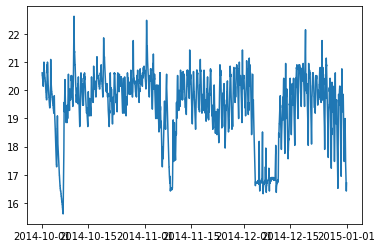

In [ ]:
# тут реалізуйте завантаження даних температур за літній місяці у df_summer, де це pandas об'єкт, який ви знаєте з перших двох лаб
df = pd.read_csv('Air temperature.csv', names=['dateTime', 'data'], parse_dates=['dateTime'])
df = df.set_index(['dateTime'])
df_summer = df[df.index.month.isin([10, 11,12])]
plt.plot(df_summer)

In [ ]:
# summer model
from sklearn.metrics import mean_squared_error
from math import sqrt, isnan
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
values = np.array(df_summer.data).reshape(-1, 1)
scaler.fit(values)
df_summer.data = scaler.transform(values)

# test for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_summer.data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# spliting time series
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values


# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model, hist = model_fit(train, cfg)
       
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
    # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    if np.isnan(hist.history['loss']).any():
        error = -1
    else:
        error = measure_rmse(test, predictions)

    aa=[x for x in range(400)]
    plt.plot(aa, test[:400], marker='.', label="actual")
    plt.plot(aa, predictions[:400], 'r', label="prediction")
    plt.ylabel('Summer Temperature', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(['actual', 'predicted'], loc='upper left')

    print( ' > %.3f ' % error)
    return model, hist, error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
    # fit and evaluate the model n times
    result = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return result

def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print( ' %s: %.3f RMSE (+/- %.3f) ' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -1.818988
p-value: 0.371076
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff, n_layers = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    if n_layers==2:
        model.add(LSTM(n_nodes, activation= 'tanh', input_shape=(n_input, 1), return_sequences=True))
        model.add(LSTM(n_nodes, activation= 'tanh'))
    else:
        model.add(LSTM(n_nodes, activation= 'tanh', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation= 'relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit
    history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1, 
                        validation_split=0.2, shuffle=False)
    '''
    # summarize history 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    '''
    return model, history

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff, _ = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

In [ ]:
# data split
n_test = 10*48

# define config, model hyperparameters
n_input = 210
n_nodes = 50
n_epochs = 20
n_batches = 50
n_diff = 0
n_layers = 1
config = [n_input, n_nodes, n_epochs, n_batches, n_diff, n_layers]

Epoch 1/20
60/60 [==============================] - 1s 19ms/step - loss: 250.0751 - accuracy: 0.0000e+00 - val_loss: 61.5770 - val_accuracy: 0.0000e+00
Epoch 2/20
60/60 [==============================] - 1s 11ms/step - loss: 14.7923 - accuracy: 0.0000e+00 - val_loss: 3.5899 - val_accuracy: 0.0000e+00
Epoch 3/20
60/60 [==============================] - 1s 11ms/step - loss: 1.4193 - accuracy: 0.0000e+00 - val_loss: 2.8321 - val_accuracy: 0.0000e+00
Epoch 4/20
60/60 [==============================] - 1s 11ms/step - loss: 1.4532 - accuracy: 0.0000e+00 - val_loss: 2.8127 - val_accuracy: 0.0000e+00
Epoch 5/20
60/60 [==============================] - 1s 11ms/step - loss: 1.4740 - accuracy: 0.0000e+00 - val_loss: 2.7674 - val_accuracy: 0.0000e+00
Epoch 6/20
60/60 [==============================] - 1s 11ms/step - loss: 1.4910 - accuracy: 0.0000e+00 - val_loss: 2.7287 - val_accuracy: 0.0000e+00
Epoch 7/20
60/60 [==============================] - 1s 11ms/step - loss: 1.5037 - accuracy: 0.0000e+00

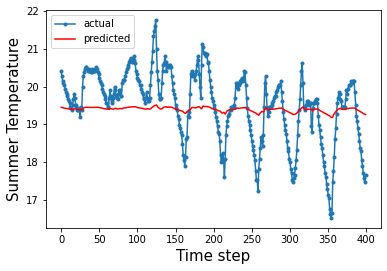

In [ ]:
# run
results = repeat_evaluate(df_summer.data.values, config, n_test)

In [ ]:
results

[(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f60ab71d6d8>,
  0.9741368994749203)]

In [ ]:
# save and read trained model
results[0][0].save("model.h5")

In [ ]:
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_152 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 51        
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# test model
def test_model(data=df_summer.data.values, n_test=n_test, model=model, cfg=config):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
       
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    test = test[:100]
    for i in range(len(test)):
    # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    aa=[x for x in range(100)]
    plt.plot(aa, test, marker='.', label="actual")
    plt.plot(aa, predictions, 'r', label="prediction")
    plt.ylabel('Summer Temperature', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(['actual', 'predicted'], loc='upper left')

    error = measure_rmse(test, predictions)
    print( ' > %.3f ' % error)
    
    return error, predictions, test

 > 0.725 


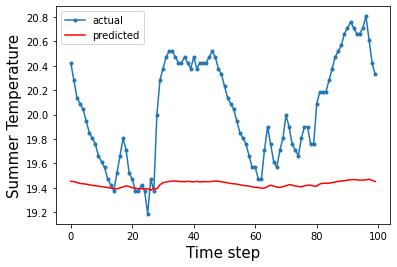

In [ ]:
error, predictions, test = test_model()

In [ ]:
# OPTIONAL!
# how to calculate hyperparameters
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [48*7, 48*10, 14*15]
    n_nodes = [20, 30, 50, 70, 100]
    n_epochs = [20]
    n_batch = [10, 30, 50, 70, 100]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l, 0, 1]
                    configs.append(cfg)
                    
    print('Total configs: %d ' % len(configs))
    return configs

In [ ]:
cfg_list = model_configs()

Total configs: 75 


In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = []
    for cfg in cfg_list:
        scores.append(repeat_evaluate(data, cfg, n_test))
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

Epoch 1/20
288/288 [==============================] - 4s 14ms/step - loss: 161.8346 - accuracy: 0.0000e+00 - val_loss: 2.3334 - val_accuracy: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 4s 13ms/step - loss: 1.3340 - accuracy: 0.0000e+00 - val_loss: 2.2798 - val_accuracy: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 4s 13ms/step - loss: 1.2292 - accuracy: 0.0000e+00 - val_loss: 2.2215 - val_accuracy: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 4s 13ms/step - loss: 1.2466 - accuracy: 0.0000e+00 - val_loss: 2.1818 - val_accuracy: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 4s 13ms/step - loss: 1.2599 - accuracy: 0.0000e+00 - val_loss: 2.1568 - val_accuracy: 0.0000e+00
Epoch 6/20
288/288 [==============================] - 4s 13ms/step - loss: 1.2697 - accuracy: 0.0000e+00 - val_loss: 2.1408 - val_accuracy: 0.0000e+00
Epoch 7/20
288/288 [==============================] - 4s 13ms/step - loss: 1.2759 - accuracy

IndexError: ignored

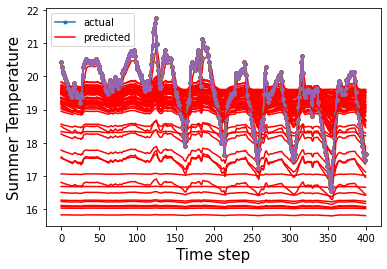

In [ ]:
scores = grid_search(df_summer.data.values, cfg_list, n_test)